# This notebook explores how to determine which model best fits the data
The data is given as a sum of exponentials, and then we fit multiple models to the data, and use Bayes factors to determine the best fit.

In [13]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

### Create a true exponential spectra with E0t and J0t parameters. 
Then use that spectra and fold it through the MagEIS response functions to get true counts as a function of energy channel.

In [14]:
# Initialize the response function
# RBSP-A MagEIS LOW LUT=16386 from 2016-01-01 (same for all day)
R = mageis_response.R_iso(101, lut=16386, magB=1065)
print('Using MagEIS calibration file: {}'.format(R._cal_file))
E = 1000*R.E # energy (keV).
n_ch = (1, 9) # Use the main rate channels and ignore the first channel which is redundant

Using MagEIS calibration file: /home/msshumko/Documents/mageis-stats/utils/mageis_response_files/low/rbsp_mageis_low_101_1065_MR_16386.mat


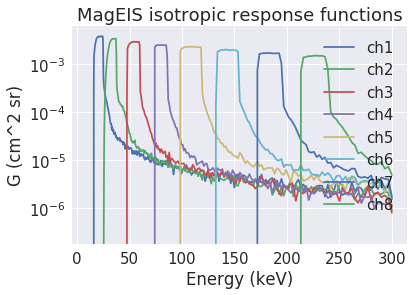

In [15]:
for i in range(*n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS isotropic response functions'); plt.yscale('log');
plt.legend(); #plt.savefig('response.png', dpi=300)

### Now get counts from a "true" spectra

In [16]:
def spectra(E, Ji, Ei):
    """
    This spectra function returns a superpositon of exponential spectra.
    """
    if hasattr(Ji, '__len__'):
        jArr = np.zeros_like(E, dtype=float)
        for (j, e) in zip(Ji, Ei):
            jArr += j*np.exp(-E/e)
        return jArr
    else:
        return(Ji*np.exp(-E/Ei))
    
def pymcSpectra(E, Ji, Ei, n):
    """
    This spectra function returns a superpositon of exponential spectra.
    """
    if 'vector' in str(Ji.type):
        jArr = len(E)*[0]
        #for (j, e) in zip(Ji, Ei):
        for i in range(n):
            #jArr += j*pm.math.exp(-E/e)
            jArr += Ji[i]*pm.math.exp(-E/Ei[i])
        return jArr
    else:
        return(Ji*np.exp(-E/Ei))
    
def pymcTrapz(f, x):
    """
    This function is the pymc3 Trapz implementation for an uneven grid.
    It integrates a function f over an uneven grid x.
    """
    return 0.5*pm.math.dot((f[1:] + f[:-1]), (x[1:] - x[:-1]))

In [17]:
FEDU_energy = [ 15.,  20.,  33.,  54.,  80., 108., 143., 184., 226.] # keV
Eit = [100, 10]
Jit = [1E3, 1E5]

Visualize the "true" energy spectra

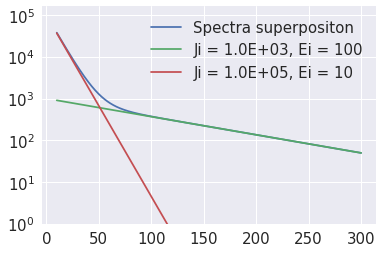

In [18]:
plt.semilogy(E, spectra(E, Jit, Eit), label='Spectra superpositon');
for (j, e) in zip(Jit, Eit):
    plt.semilogy(E, spectra(E, j, e), label='Ji = {:.1E}, Ei = {}'.format(j, e));
plt.legend(); plt.ylim(bottom=1);

Get the true observed counts as a function of energy channel

In [19]:
true_lambda = np.nan*np.zeros(n_ch[1]-n_ch[0])
for i in range(*n_ch):
    true_lambda[i-n_ch[0]] = scipy.integrate.trapz(
        spectra(E, Jit, Eit)*R.response(i), x=E)

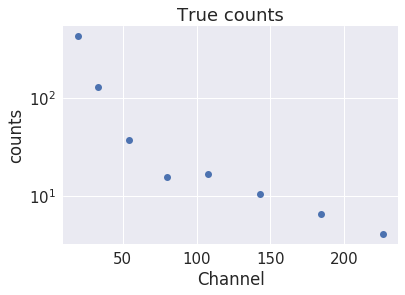

In [20]:
plt.semilogy(FEDU_energy[n_ch[0]:n_ch[1]], true_lambda, 'o'); 
plt.ylabel('counts'); plt.xlabel('Channel'); plt.title('True counts');

Now add realism by drawing observed counts from true_lambda assuming a Poisson process

In [21]:
np.random.seed(123)
c_obs = np.random.poisson(true_lambda)

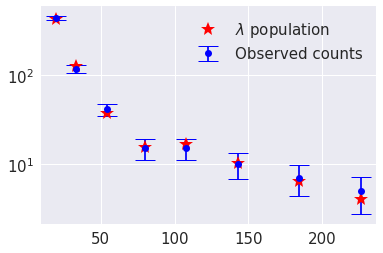

In [22]:
(_, caps, _) = plt.errorbar(FEDU_energy[n_ch[0]:n_ch[1]], c_obs, yerr=np.sqrt(c_obs), c='b', fmt='o', 
                            label='Observed counts', capsize=10)
for cap in caps:
    cap.set_markeredgewidth(1)
plt.plot(FEDU_energy[n_ch[0]:n_ch[1]], true_lambda, 'r*', ms=15, 
         label=r'$\lambda$ population')
plt.yscale('log'); plt.legend();

### The bayes model

In [23]:
m = pm.Model()

def lam(Ji, Ei, n):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    My implementation of trapezium is not the fastest, but it will do.
    """
    lams = len(c_obs)*[None]
    
    for i in range(len(c_obs)):
        J = pymcSpectra(E, Ji, Ei, n)
        #f is chanel-dependent offset * flux arr * interpolated 
        # G(E * a random energy offset)
        f = J*R.response(i+n_ch[0])  #G(E*Eoffset[i])[i] 
        lams[i] = pm.Deterministic('lam{}'.format(i), pymcTrapz(f, E))
    return lams

with m:
    # Prior stocastic variables
    n = 2
    Ji = pm.Uniform('Ji', lower=1, upper=5E7, shape=n)
    Ei = pm.Uniform('Ei', lower=1/1000, upper=300, shape=n)
    
    lams = lam(Ji, Ei, n)
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs))
    trace = pm.sample(1E4, tuning=1000, cores=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [Ei_interval__, Ji_interval__]
  6%|▌         | 633/10500.0 [00:09<02:23, 68.93it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '23745' (I am process '23746')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/msshumko/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-redhat-7.5-Maipo-x86_64-3.6.0-64/lock_dir
100%|██████████| 10500/10500.0 [02:15<00:00, 77.54it/s]
The acceptance probability does not match the target. It is 0.9467130358621442, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9194923602469854, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9031092340662864, but should be close to 0.8. Try to increase the number of tuning steps.
Th

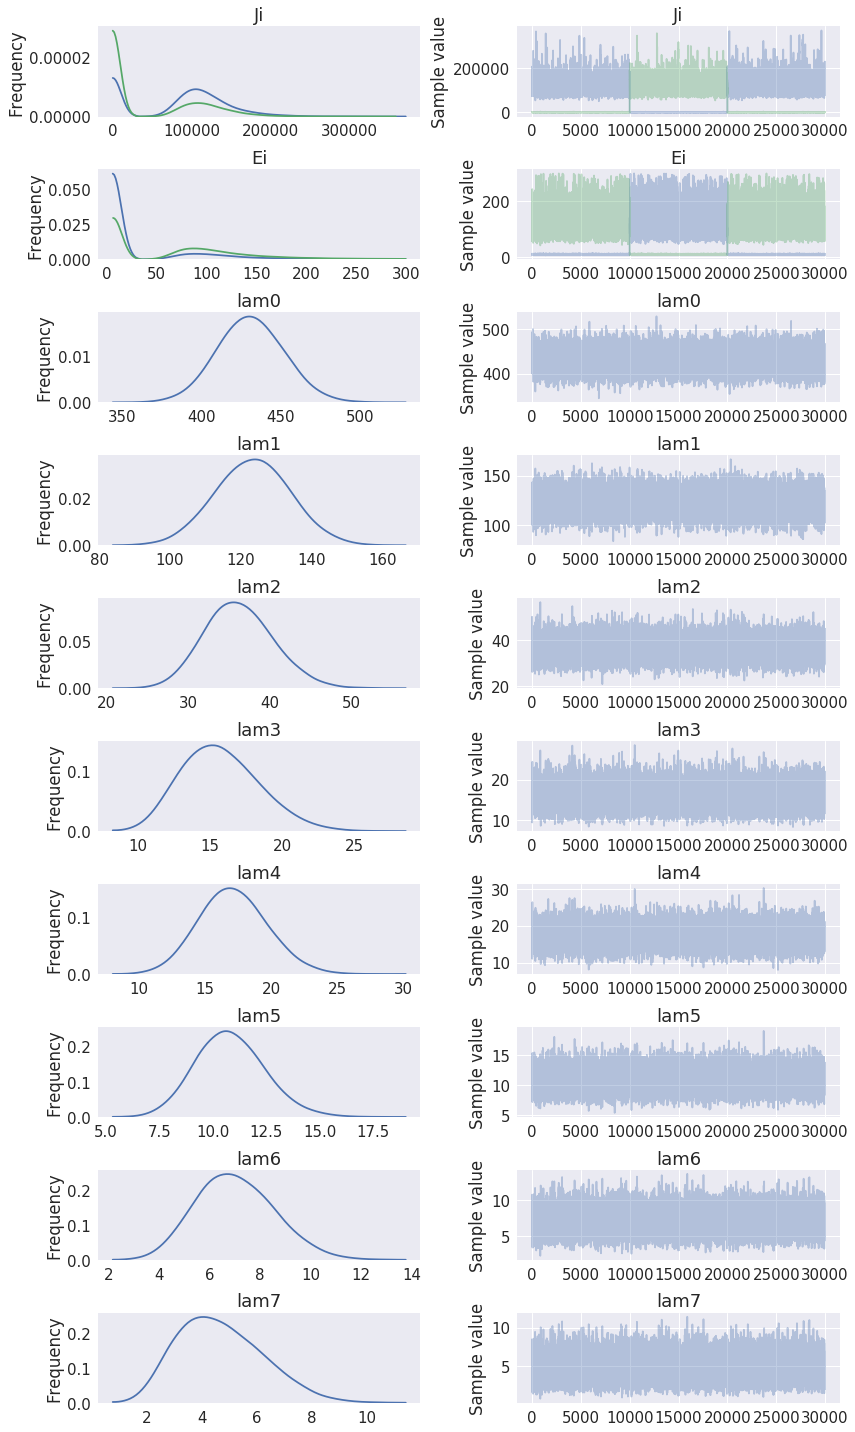

In [24]:
pm.traceplot(trace, combined=True);

In [25]:
pm.summary(trace)

mean            sd     mc_error     hpd_2.5       hpd_97.5  \
Ji__0  80357.586513  62538.630224  5559.464868  253.662381  172964.467413   
Ji__1  40893.390452  59253.712476  5584.197562  289.187927  151301.463493   
Ei__0     46.277240     59.091081     5.150659    6.118945     168.419591   
Ei__1     83.907146     66.666584     5.243468    6.364364     209.534533   
lam0     430.681527     20.704598     0.152822  390.787325     471.962056   
lam1     123.176429     10.490499     0.109370  103.125761     144.169244   
lam2      36.150080      4.172451     0.032465   28.274597      44.443287   
lam3      15.715354      2.680713     0.030040   10.858918      21.108134   
lam4      17.092240      2.551890     0.022915   12.168564      22.182127   
lam5      10.794260      1.594421     0.008197    7.805564      14.036057   
lam6       7.012413      1.544068     0.014023    4.210661      10.133890   
lam7       4.663168      1.536695     0.017120    1.910190       7.616801   

              n_eff      Rhat  
Ji__0      1.758750  2.673749  
Ji__1      1.614827  3.886268  
Ei__0      1.820016  2.473558  
Ei__1      2.152212  1.865421  
lam0   19216.058913  1.000396  
lam1    8948.378570  1.000227  
lam2   15004.474009  1.000144  
lam3    7794.457087  0.999985  
lam4   11211.841834  1.000027  
lam5   26349.321055  0.999977  
lam6   11870.430906  1.000006  
lam7    8114.044072  1.000067

In [26]:
c_mean = [np.mean(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_std = [np.std(trace['lam{}'.format(i)]) for i in range(len(c_obs))]
c_ci = np.asarray([np.percentile(trace['lam{}'.format(i)], (2.5, 97.5)) 
                    for i in range(len(c_obs))])

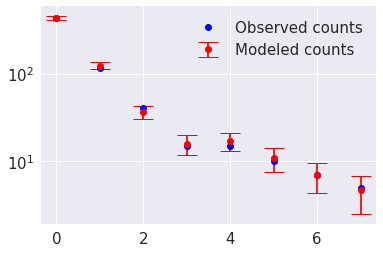

In [27]:
(_, caps, _) = plt.errorbar(range(len(c_obs)), c_mean, yerr=np.sqrt(c_mean), 
                            c='r', fmt='o', capsize=10, label='Modeled counts'); 
for cap in caps:
    cap.set_markeredgewidth(1)
plt.plot(range(len(c_obs)), c_obs, 'bo', label='Observed counts'); 
plt.legend(); plt.yscale('log')